<div class="alert alert-block alert-info">
Section of the book chapter: <b>3. Regression on Data Level</b>
</div>

# 1. Data Level


**Table of Contents**

* [1.1 Data handling](#1.1-Data-handling)
* [1.2 Dataset shift](#1.2-Dataset-shift)
* [1.3 Dataset splitting](#1.3-Dataset-splitting)


**Learnings:**

- how to read in, validate and scale data,
- how datashift looks like in a real world example,
- how to split datasets with random, systematic, patch and stratified split.


### Packages

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
from patchify import patchify
from sklearn.ensemble import RandomForestRegressor
import importlib

import utils

### Read in Data

**Dataset:** Felix M. Riese and Sina Keller, "Hyperspectral benchmark dataset on soil moisture", Dataset, Zenodo, 2018. [DOI:10.5281/zenodo.1227836](http://doi.org/10.5281/zenodo.1227836) and [GitHub](https://github.com/felixriese/hyperspectral-soilmoisture-dataset)

**Introducing paper:** Felix M. Riese and Sina Keller, “Introducing a Framework of Self-Organizing Maps for Regression of Soil Moisture with Hyperspectral Data,” in IGARSS 2018 - 2018 IEEE International Geoscience and Remote Sensing Symposium, Valencia, Spain, 2018, pp. 6151-6154. [DOI:10.1109/IGARSS.2018.8517812](https://doi.org/10.1109/IGARSS.2018.8517812)

In [2]:
importlib.reload(utils)
X, y = utils.get_xy()
# X = X.T


ValueError: could not broadcast input array from shape (150,11,11) into shape (150,)

### Plot Configurations

In [27]:
norm = mpl.colors.Normalize(vmin=np.min(y), vmax=np.max(y))
cmap = "cividis_r"


myblue = "#4664ab"
myblue30 = "#c7d0e6"
myred = "#9b1724"

### Fix Random State

(10, 268, 284)
(268, 284)


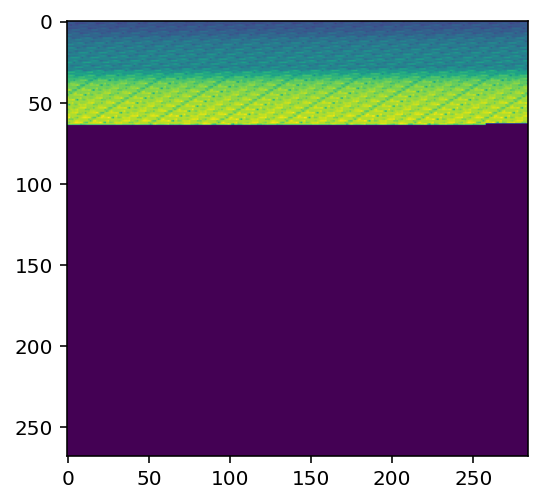

In [74]:
print(X.shape)
print(X[0].shape)
plt.imshow(X[0])
plt.show()
np.random.seed(42)

***

## 1.1 Data handling

Steps:

- [1.1.1 Collect the data](#1.1.1-Collect-the-data)
- [1.1.2 Validate the data](#1.1.2-Validate-the-data)
- [1.1.3 Prepare the data](#1.1.3-Prepare-the-data)

### 1.1.1 Collect the data

Columns:

* `0` - `124`: 125 hyperspectral bands
* `soil_moisture`: target variable of soil moisture in percent

In [29]:

#TODO: think about how to deal with the different sample sizes properly.

df = pd.DataFrame(X) 
df["pH"] = y


### 1.1.2 Validate the data

In [30]:
# dataset statistics
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,76103,76104,76105,76106,76107,76108,76109,76110,76111,pH
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000
mean,370.870903,370.870903,370.870903,371.050697,371.944734,371.933580,369.337668,369.182686,370.702816,370.768472,...,277.868459,278.056685,278.476685,278.694261,278.679532,278.749532,276.758306,273.685661,275.942592,7.13400
std,104.425124,104.425124,104.425124,104.479121,106.907646,103.737558,99.767018,99.134497,104.399728,104.154544,...,242.761990,242.511643,243.548378,242.434074,241.921415,241.103945,239.853133,238.436347,239.637903,0.20162
min,196.380952,196.380952,196.380952,196.380952,196.380952,196.380952,196.380952,196.380952,196.380952,196.380952,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.70000
25%,296.246619,296.246619,296.246619,296.246619,296.246619,296.246619,296.246619,296.246619,296.246619,296.322813,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.00000
50%,363.057466,363.057466,363.057466,363.057466,363.139511,363.139511,363.848279,362.791232,363.057466,361.336104,...,319.641898,322.546798,327.037390,320.546798,325.537390,319.641898,319.641898,317.595100,322.595100,7.20000
75%,413.573880,413.573880,413.573880,412.715555,413.698718,415.795982,408.693647,413.573880,413.573880,413.573880,...,424.750000,430.500000,424.095257,427.845257,433.095257,440.285772,439.535772,419.000000,430.000000,7.30000
max,819.025641,819.025641,819.025641,819.025641,849.000000,751.000000,719.000000,687.692308,819.025641,819.025641,...,764.474301,764.474301,780.000000,764.474301,764.474301,764.474301,764.474301,764.474301,764.474301,7.50000


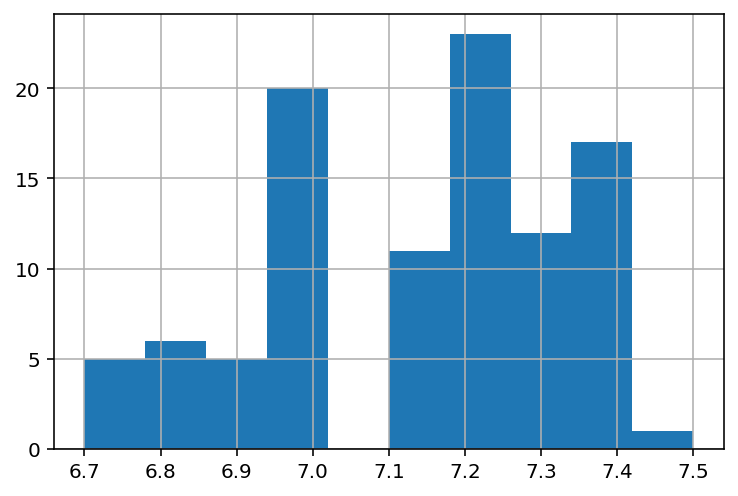

In [31]:
# target variable distribution
df["pH"].hist()
plt.show()

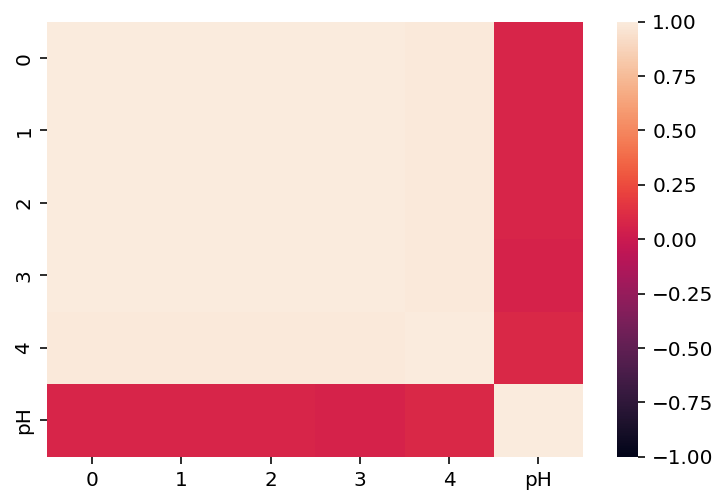

In [33]:
# correlations of different features and the target variable in a heatmap
sns.heatmap(df[[0, 1, 2, 3, 4, "pH"]].corr(), vmin=-1., vmax=1.)
plt.show()

### 1.1.3 Prepare the data

We use the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to scale our data. The resulting `X_scaled` is the scaled input data `X`.

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

***

## 1.2 Dataset shift

Content:

- [1.2.1 Generate shifted dataset](#1.2.1-Generate-shifted-dataset)
- [1.2.2 Simple regression](#1.2.2-Simple-regression)

### 1.2.1 Generate shifted dataset

In [42]:
# get shifted data (Kai: we're not shifting the data)
importlib.reload(utils)

X_train, X_test, y_test, y_train = utils.get_xy_split()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(250, 76112) (250,) (250, 76112) (250,)


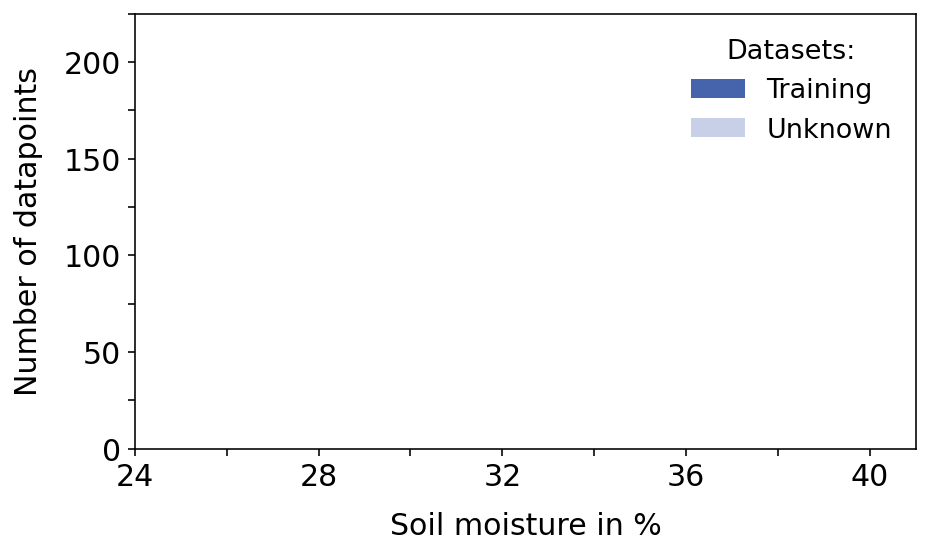

In [38]:
# plot shifted data
fontsize = 15

fig, ax = plt.subplots(1,1, figsize=(7,4))

bins = np.arange(25., 42.5, 2.5)
plt.hist(y_train, bins=bins, label="Training", alpha=1.0, color=myblue)
plt.hist(y_test, bins=bins, label="Unknown", alpha=1.0, color=myblue30)

lfact = 0.9
leg = plt.legend(title="Datasets:", fontsize=fontsize*lfact, frameon=False)
plt.setp(leg.get_title(), fontsize=fontsize*lfact)

plt.xlabel("Soil moisture in %", fontsize=fontsize, labelpad=10)
plt.ylabel("Number of datapoints", fontsize=fontsize, labelpad=10)
plt.xlim(24, 41)
plt.ylim(0, 225)

for tick in ax.xaxis.get_major_ticks()[1::2]:
    tick.label.set_visible(False)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize) 
for tick in ax.yaxis.get_major_ticks()[1::2]:
    tick.label.set_visible(False)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize) 
    
plt.savefig("plots/datasetshift_distributions.pdf", bbox_inches="tight")

### 1.2.2 Simple regression

In [43]:
model = RandomForestRegressor(n_estimators=100, n_jobs=-1)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("R2 = {0:.2f} %".format(score*100))

R2 = -5.51 %


***

## 1.3 Dataset splitting

Content:

- [1.3.1 Random Split](#1.3.1-Random-Split)
- [1.3.2 Split plot](#1.3.2-Split-plot)

### 1.3.1 Random Split

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, shuffle=True)

### 1.3.2 Split plot

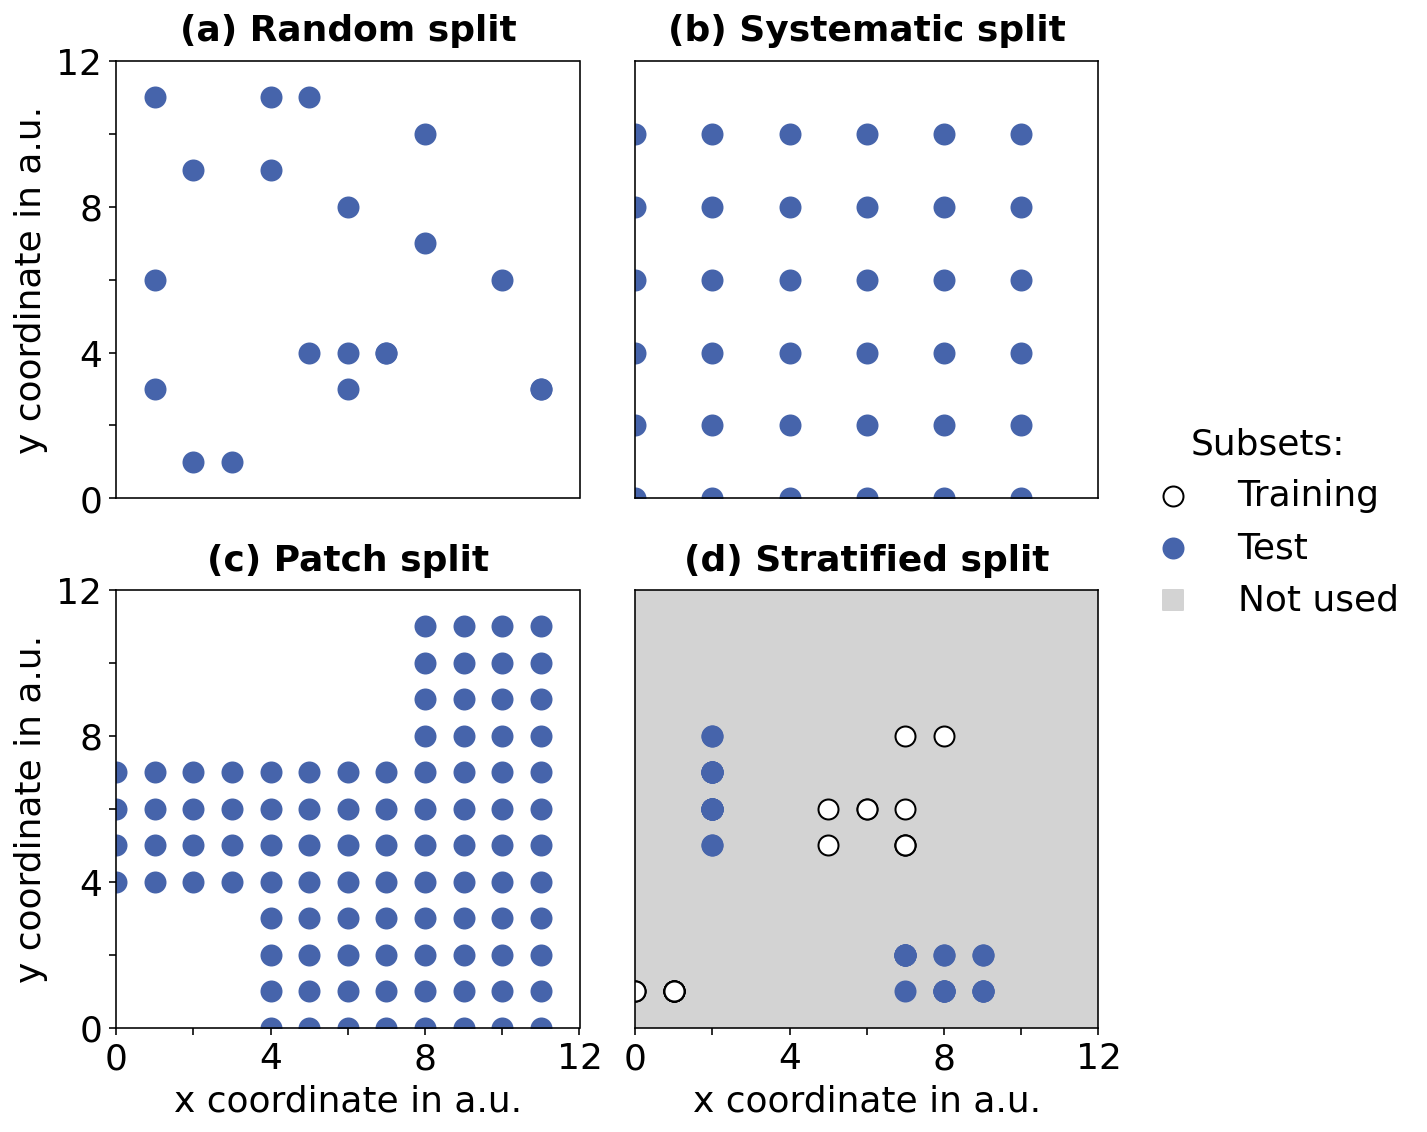

In [45]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8,8))
axes = [ax1, ax2, ax3, ax4]

fontsize = 18
titleweight = "bold"
titlepad = 10
msize = 100
il = 12     # image length

# random split
data_rand = np.random.randint(low=1, high=il, size=(20,20))
ax1.scatter(data_rand[0], data_rand[1], marker="o", color=myblue, s=msize)
ax1.set_title("(a) Random split", fontsize=fontsize, fontweight=titleweight, pad=titlepad)

# systematic split
k = 2
data_sys = [(x, y) for (x, y) in itertools.product(range(il), range(il)) if ((x % k == 0) and (y % k == 0))]
ax2.scatter([x[0] for x in data_sys], [x[1] for x in data_sys], marker="o", color=myblue, s=msize)
ax2.set_title("(b) Systematic split", fontsize=fontsize, fontweight=titleweight, pad=titlepad)

# patch split
data_pat = np.zeros((il, il), dtype=tuple)
for i in range(il):
    for j in range(il):
        data_pat[i, j] = (i,j)
patches = patchify(data_pat, (4, 4), step=4).reshape(3*3, 4*4)
split_mask = np.random.rand(il) < 0.5
patches_train = []
patches_test = []
for p in range(patches.shape[0]):
    if split_mask[p]:
        patches_train.append(patches[p])
    else:
        patches_test.append(patches[p])
ax3.scatter([x[0] for p in patches_train for x in p], [x[1] for p in patches_train for x in p],
            marker="o", color=myblue, edgecolor=myblue, s=msize)
ax3.set_title("(c) Patch split", fontsize=fontsize, fontweight=titleweight, pad=titlepad)

# stratified split
data_strat_1 = np.random.randint(low=0, high=2, size=(10,10))
data_strat_2 = np.random.randint(low=5, high=9, size=(10,10))
data_strat_3 = [(np.random.randint(low=2, high=3), np.random.randint(low=5, high=9)) for _ in range(20)]
data_strat_4 = [(np.random.randint(low=7, high=10), np.random.randint(low=1, high=3)) for _ in range(20)]
ax4.scatter([x[0] for x in data_strat_1], [x[1] for x in data_strat_1],
            marker="o", color="white", edgecolor="black", s=msize)
l_train = ax4.scatter([x[0] for x in data_strat_2], [x[1] for x in data_strat_2],
                      marker="o", color="white", edgecolor="black", s=msize)
ax4.scatter([x[0] for x in data_strat_3], [x[1] for x in data_strat_3], marker="o", color=myblue, s=msize)
l_test = ax4.scatter([x[0] for x in data_strat_4], [x[1] for x in data_strat_4],
                     marker="o", color=myblue, s=msize)
l_not = ax4.scatter([], [], marker="s", color="lightgrey", s=msize) #, edgecolor="grey")
ax4.set_facecolor("lightgrey")
ax4.set_title("(d) Stratified split", fontsize=fontsize, fontweight=titleweight, pad=titlepad)

for i, ax in enumerate(axes):
    ax.set_xlim(0,12)
    ax.set_ylim(0,12)
    # ax.set_xlim(-1,101)
    # ax.set_ylim(-1,101)
    ax.set_xlabel("x coordinate in a.u.", fontsize=fontsize)
    ax.set_ylabel("y coordinate in a.u.", fontsize=fontsize)
    
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.label.set_visible(False)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize) 
    for tick in ax.yaxis.get_major_ticks()[1::2]:
        tick.label.set_visible(False)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize) 
    
    if i != 0 and i != 2:
        ax.yaxis.set_visible(False)
        
    if i != 2 and i != 3:
        ax.xaxis.set_visible(False)

        
leg = fig.legend(
    (l_train, l_test, l_not), ("Training", "Test", "Not used"),
    bbox_to_anchor=(1.25, 0.65), title="Subsets:", ncol=1, fontsize=fontsize, frameon=False)
frame = leg.get_frame()
plt.setp(leg.get_title(), fontsize=fontsize)

plt.tight_layout()
plt.savefig("plots/split_approaches.pdf", bbox_inches="tight")